Tokenze Text 

In [51]:
# Import Required Libariries
import pandas as pd
from collections import Counter

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries
import re
from nltk.stem import PorterStemmer
import spacy
from spacy.tokenizer import Tokenizer


# Data exploration

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, mean_absolute_error

%matplotlib inline

In [4]:
url = 'https://raw.githubusercontent.com/WhyseRabbit/med-cabinet-ds/feature/tensor_effects/data/cannabis.csv'
df = pd.read_csv(url)
df.head()

,Strain,Type,Rating,Effects,Flavor,Description
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",$100 OG is a 50/50 hybrid strain that packs a ...
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",The ‘98 Aloha White Widow is an especially pot...
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1024 is a sativa-dominant hybrid bred in Spain...
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",13 Dawgs is a hybrid of G13 and Chemdawg genet...
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange","Also known as Kosher Tangie, 24k Gold is a 60%..."


In [5]:
def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
    tokens = re.sub('[^a-zA-Z 0-9]', '', str(text))
    tokens = tokens.lower().split()
    
    return tokens

In [6]:
# Notice anything odd here? 
df['Type'].value_counts()

hybrid    1212
indica     699
sativa     440
Name: Type, dtype: int64

In [7]:
# Count the raw text
df['Description'].value_counts(normalize=True)[:50]

None                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        0.001726
Blue Trainwreck is a sativa-dominant hybrid cross of Trainwreck and Blueberry. This strain, sometimes known as Blueberry Trainwreck, Blue Wreck, and Blue Train, is well-loved for its pleasurable blend of flavors and effects. It expresses trichome-laden spade-shaped buds that are emerald green with amber hairs. Blue Trainwreck offers a sweet blueberry ar

In [8]:
df['base_tokens'] = df['Description'].apply(tokenize)
df['base_tokens'].head()

0    [100, og, is, a, 5050, hybrid, strain, that, p...
1    [the, 98, aloha, white, widow, is, an, especia...
2    [1024, is, a, sativadominant, hybrid, bred, in...
3    [13, dawgs, is, a, hybrid, of, g13, and, chemd...
4    [also, known, as, kosher, tangie, 24k, gold, i...
Name: base_tokens, dtype: object

In [9]:
df[['Description', 'base_tokens']][:10]

,Description,base_tokens
0,$100 OG is a 50/50 hybrid strain that packs a ...,"[100, og, is, a, 5050, hybrid, strain, that, p..."
1,The ‘98 Aloha White Widow is an especially pot...,"[the, 98, aloha, white, widow, is, an, especia..."
2,1024 is a sativa-dominant hybrid bred in Spain...,"[1024, is, a, sativadominant, hybrid, bred, in..."
3,13 Dawgs is a hybrid of G13 and Chemdawg genet...,"[13, dawgs, is, a, hybrid, of, g13, and, chemd..."
4,"Also known as Kosher Tangie, 24k Gold is a 60%...","[also, known, as, kosher, tangie, 24k, gold, i..."
5,3 Bears OG by Mephisto Genetics is an autoflow...,"[3, bears, og, by, mephisto, genetics, is, an,..."
6,"The 3 Kings marijuana strain, a holy trinity o...","[the, 3, kings, marijuana, strain, a, holy, tr..."
7,The indica-dominant 303 OG is a Colorado strai...,"[the, indicadominant, 303, og, is, a, colorado..."
8,3D CBD from Snoop Dogg’s branded line of canna...,"[3d, cbd, from, snoop, doggs, branded, line, o..."
9,"Also known as Optimus Prime, the indica-domina...","[also, known, as, optimus, prime, the, indicad..."


In [10]:
df['base_tokens'] = df['Description'].astype(str)
df['base_tokens'].head()

0    $100 OG is a 50/50 hybrid strain that packs a ...
1    The ‘98 Aloha White Widow is an especially pot...
2    1024 is a sativa-dominant hybrid bred in Spain...
3    13 Dawgs is a hybrid of G13 and Chemdawg genet...
4    Also known as Kosher Tangie, 24k Gold is a 60%...
Name: base_tokens, dtype: object

In [11]:
df['Type'].value_counts()

hybrid    1212
indica     699
sativa     440
Name: Type, dtype: int64

In [12]:
#df = df[df['Type'] == 'hybrid'].copy()
#df.head(3)

Analyzing Tokens

In [13]:
# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
word_counts = Counter()

# Update it based on a split of each of our documents
df['base_tokens'].apply(lambda x: word_counts.update(x))

# Print out the 10 most common words
word_counts.most_common(10)

[(' ', 168593),
 ('e', 92978),
 ('a', 74727),
 ('i', 68020),
 ('t', 67621),
 ('s', 61201),
 ('n', 61162),
 ('o', 53109),
 ('r', 52618),
 ('h', 34672)]

In [14]:
def count(docs):
    '''This function takes a list of tokenized documents as input and returns
    a dataframe with frequency counts and rank for each token.
    
    # Arguments
        docs: list, tokenized list of documents
        
    # Returns
        wc: dataframe, 
    '''
    
    word_counts = Counter()
    appears_in = Counter()

    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        appears_in.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    wc['pct_total'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')
    wc['cul_pct_total'] = wc['pct_total'].cumsum()

    t2 = zip(appears_in.keys(), appears_in.values())
    ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
    wc = ac.merge(wc, on='word')

    wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [15]:
# Use the Function
wc = count(df['base_tokens'])
print(wc.shape)
wc.head()

(96, 7)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
1,,2314,168593,1.0,0.160040,0.160040,0.984262
32,e,2317,92978,2.0,0.088261,0.248300,0.985538
10,a,2347,74727,3.0,0.070936,0.319236,0.998299
20,i,2314,68020,4.0,0.064569,0.383805,0.984262
13,t,2314,67621,5.0,0.064190,0.447995,0.984262


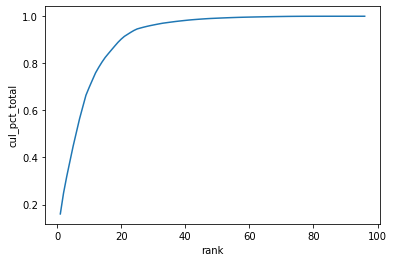

In [16]:
# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [17]:
wc[wc['rank'] <= 100]['cul_pct_total'].max()

1.0

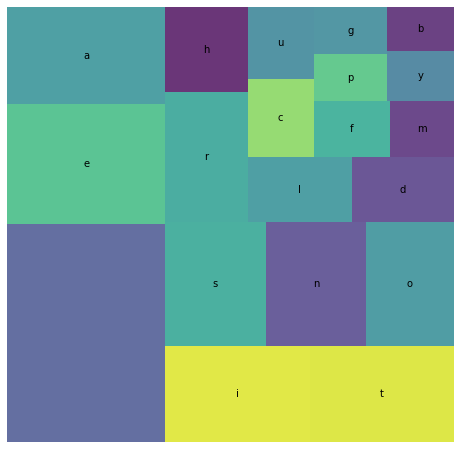

In [18]:
wc_top20 = wc[wc['rank'] <= 20]

plt.figure(figsize=(8,8))
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

Processing Raw Text with Spacy

In [19]:
# Inialize spaCy model and tokenizer
nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

In [20]:
df['Description'].astype(str)

0       $100 OG is a 50/50 hybrid strain that packs a ...
1       The ‘98 Aloha White Widow is an especially pot...
2       1024 is a sativa-dominant hybrid bred in Spain...
3       13 Dawgs is a hybrid of G13 and Chemdawg genet...
4       Also known as Kosher Tangie, 24k Gold is a 60%...
                              ...                        
2346    Zeus OG is a hybrid cross between Pineapple OG...
2347    Zkittlez is an indica-dominant mix of Grape Ap...
2348    Zombie Kush by Ripper Seeds comes from two dif...
2349    If you’re looking to transform into a flesh-ea...
2350    Zoom Pie (also known as Zombie Pie) is a heavy...
Name: Description, Length: 2351, dtype: object

In [21]:
# Make them tokens using the Tokenizer Pipe
tokens = []
for doc in tokenizer.pipe(df['base_tokens'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)
    #tokens += str(doc)

df['spaCy_tokens'] = tokens
df['spaCy_tokens'].head()

0    [$100, OG, is, a, 50/50, hybrid, strain, that,...
1    [The, ‘98, Aloha, White, Widow, is, an, especi...
2    [1024, is, a, sativa-dominant, hybrid, bred, i...
3    [13, Dawgs, is, a, hybrid, of, G13, and, Chemd...
4    [Also, known, as, Kosher, Tangie,, 24k, Gold, ...
Name: spaCy_tokens, dtype: object

In [22]:
wc = count(df['spaCy_tokens'])
print(wc.shape)
wc.head()

(15475, 7)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
3,and,2231,7323,1.0,0.042067,0.042067,0.948958
16,a,2188,6121,2.0,0.035162,0.077229,0.930668
53,the,1898,4822,3.0,0.027700,0.104929,0.807316
47,of,1968,4566,4.0,0.026229,0.131159,0.837091
54,is,2132,3849,5.0,0.022111,0.153269,0.906848


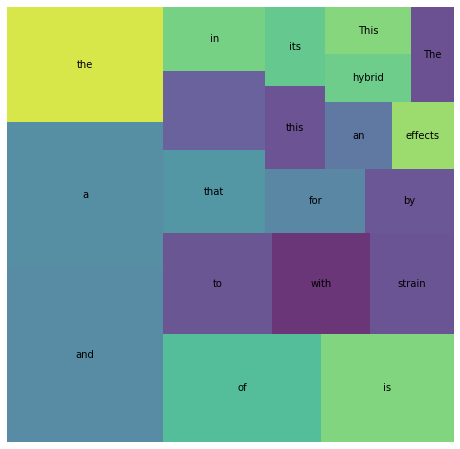

In [23]:
wc_top20 = wc[wc['rank'] <= 20]

plt.figure(figsize=(8,8))
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

Default Stop Words
Let's take a look at the standard stop words that came with our Spacy model:

In [24]:
# Spacy's Default Stop Words
nlp.Defaults.stop_words

{"'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'fron

In [25]:
tokens = []

# Return lower case tokens and ignore stop words/punctuation
for doc in tokenizer.pipe(df['base_tokens'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc:
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

df['spaCy_tokens_v2'] = tokens
df['spaCy_tokens_v2'].head()

0    [$100, og, 50/50, hybrid, strain, packs, stron...
1    [‘98, aloha, white, widow, especially, potent,...
2    [1024, sativa-dominant, hybrid, bred, spain, m...
3    [13, dawgs, hybrid, g13, chemdawg, genetics, b...
4    [known, kosher, tangie,, 24k, gold, 60%, indic...
Name: spaCy_tokens_v2, dtype: object

In [26]:
wc = count(df['spaCy_tokens_v2'])
print(wc.shape)
wc.head()

(13968, 7)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
5,strain,1572,2276,1.0,0.021033,0.021033,0.668652
44,,1158,2138,2.0,0.019758,0.040790,0.492556
148,effects,968,1121,3.0,0.010359,0.051150,0.411740
11,hybrid,984,1115,4.0,0.010304,0.061453,0.418545
19,og,441,882,5.0,0.008151,0.069604,0.187580


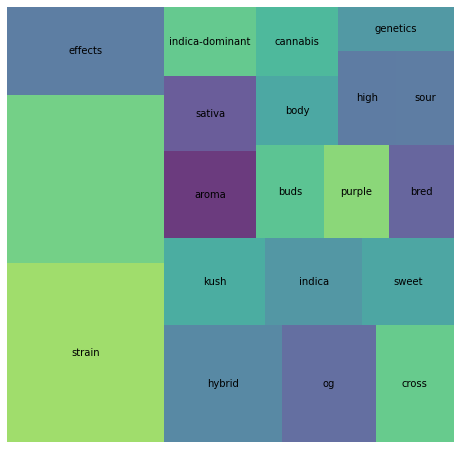

In [27]:
wc_top20 = wc[wc['rank'] <= 20]

plt.figure(figsize=(8,8))
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

Extending Stop Words

In [28]:
print(type(nlp.Defaults.stop_words))

<class 'set'>


In [29]:
STOP_WORDS = nlp.Defaults.stop_words.union([' ','I', 'og', 'i', 'body', 'it', "it's", 'it.', 'the', 'this'])
STOP_WORDS

{' ',
 "'d",
 "'ll",
 "'m",
 "'re",
 "'s",
 "'ve",
 'I',
 'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'body',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'f

In [30]:
tokens = []
for doc in tokenizer.pipe(df['base_tokens'], batch_size=500):
    
    doc_tokens = []
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
df['spaCy_tokens_v3'] = tokens

In [31]:
wc = count(df['spaCy_tokens_v3'])
print(wc.shape)
wc.head()

(13969, 7)


,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
5,strain,1572,2276,1.0,0.021297,0.021297,0.668652
42,,1158,2138,2.0,0.020005,0.041302,0.492556
146,effects,968,1121,3.0,0.010489,0.051791,0.411740
11,hybrid,984,1115,4.0,0.010433,0.062224,0.418545
211,cross,716,738,5.0,0.006905,0.069129,0.304551


In [32]:
# To make this comparison more interesting, let's compare
df['hybrid'] = df['Type'].str.contains('hybrid', case=False)
df['indica'] = df['Type'].str.contains('indica', case=False)

(13969, 7) (9578, 7) (6928, 7)


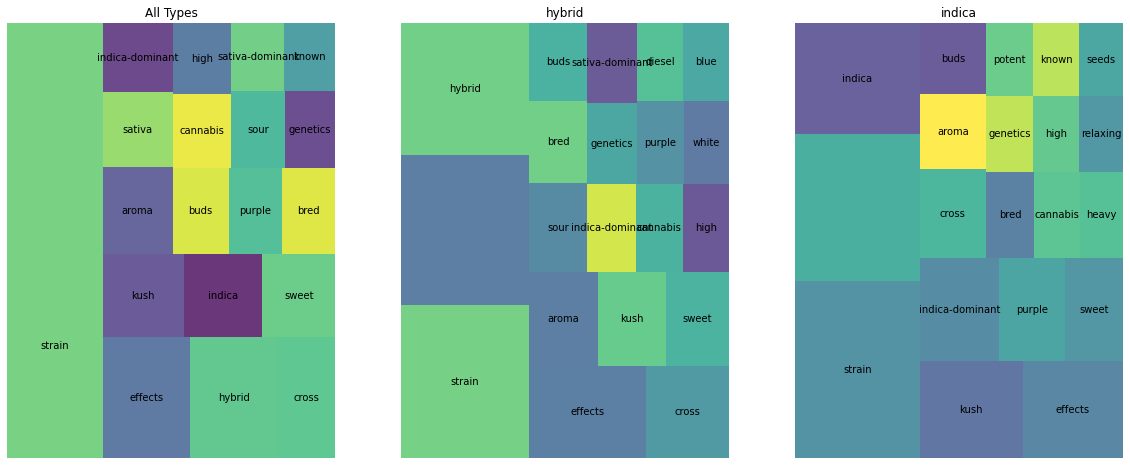

In [33]:
# Use the Function for all reviews
wc = count(df['spaCy_tokens_v3'])
wc_hybrid = count(df[df['hybrid'] == 1]['spaCy_tokens_v3'])
wc_indica = count(df[df['indica'] == 1]['spaCy_tokens_v3'])
print(wc.shape, wc_hybrid.shape, wc_indica.shape)

# Get top 20 word occurences for each set of data
wc_top20 = wc[wc['rank'] <= 20]
wc_hybrid_top20 = wc_hybrid[wc_hybrid['rank'] <= 20]
wc_indica_top20 = wc_indica[wc_indica['rank'] <= 20]

fig, axes = plt.subplots(1, 3, figsize=(20, 8))

axes[0].set_title('All Types')
squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8, ax=axes[0])
axes[0].axis('off')

axes[1].set_title('hybrid')
squarify.plot(sizes=wc_hybrid_top20['pct_total'], label=wc_hybrid_top20['word'], alpha=.8, ax=axes[1])
axes[1].axis('off')

axes[2].set_title('indica')
squarify.plot(sizes=wc_indica_top20['pct_total'], label=wc_indica_top20['word'], alpha=.8, ax=axes[2])
axes[2].axis('off')
plt.show()

In [34]:
df['Type'].value_counts()

hybrid    1212
indica     699
sativa     440
Name: Type, dtype: int64

In [35]:
df['Rating'].value_counts()

4.5    317
4.3    297
4.4    284
4.6    242
4.2    225
5.0    210
4.7    164
4.8    159
4.0    104
4.1    101
0.0     71
4.9     59
3.9     29
3.8     23
3.7     16
3.0     13
3.6     11
3.5      9
3.4      5
3.2      3
3.3      3
2.0      2
2.8      1
1.0      1
3.1      1
2.5      1
Name: Rating, dtype: int64

Statistical Trimming

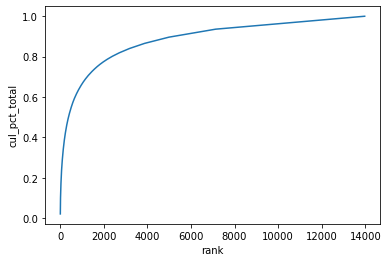

In [36]:
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [37]:
wc.tail(20)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
13945,napoli,1,1,13950.0,0.000009,0.999822,0.000425
13948,ucla,1,1,13951.0,0.000009,0.999832,0.000425
13959,transform,1,1,13952.0,0.000009,0.999841,0.000425
13955,flesh-eating,1,1,13953.0,0.000009,0.999850,0.000425
13956,"monster,",1,1,13954.0,0.000009,0.999860,0.000425
13952,fridge,1,1,13955.0,0.000009,0.999869,0.000425
13951,catatonic,1,1,13956.0,0.000009,0.999878,0.000425
13960,them).,1,1,13957.0,0.000009,0.999888,0.000425
13957,rampage,1,1,13958.0,0.000009,0.999897,0.000425
13958,city.,1,1,13959.0,0.000009,0.999906,0.000425


In [38]:
wc['appears_in_pct'].describe()

count    13969.000000
mean         0.002957
std          0.013488
min          0.000425
25%          0.000425
50%          0.000425
75%          0.001701
max          0.668652
Name: appears_in_pct, dtype: float64

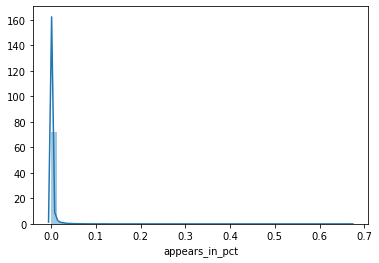

In [39]:
# Frequency of appears in documents
sns.distplot(wc['appears_in_pct']);

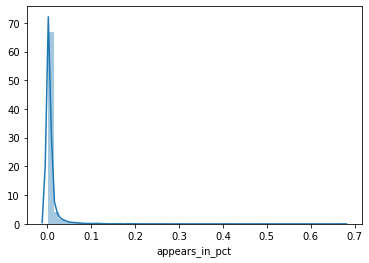

In [40]:
# Tree-Map w/ Words that appear in a least 0.1% of documents. 
wc = wc[wc['appears_in_pct'] >= 0.001]
sns.distplot(wc['appears_in_pct']);

In [41]:
wc.shape

(4559, 7)

In [42]:
wc.tail()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
12435,power.,3,3,4891.0,0.000028,0.894341,0.001276
12515,user,3,3,4893.0,0.000028,0.894397,0.001276
12830,"fact,",3,3,4899.0,0.000028,0.894565,0.001276
12956,genetix.,3,3,4903.0,0.000028,0.894678,0.001276
13227,terms,3,3,4907.0,0.000028,0.894790,0.001276


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marianvinas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/marianvinas/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marianvinas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


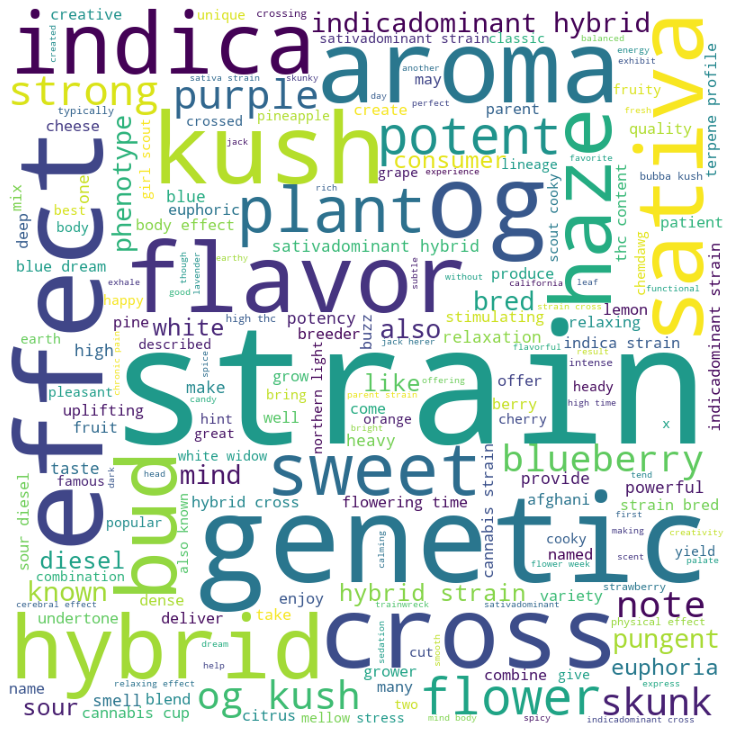

In [71]:
# imports
import nltk
nltk.download(['punkt', 'wordnet', 'stopwords'])
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import re


comment_words = ''
stop_words = set(stopwords.words('english'))

for val in df.base_tokens:
    val = str(val)
    tokens = word_tokenize(val)
    tokens = re.sub('[^a-zA-Z 0-9]', '', val)
    tokens = tokens.lower().split()
    lemmatizer = WordNetLemmatizer()
    tokens = [w for w in tokens if not w in stop_words]
    tokens = [lemmatizer.lemmatize(w.lower().strip()) for w in tokens]
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                     background_color='white',
                     stopwords = stop_words,
                     min_font_size = 10).generate(comment_words)

plt.figure(figsize = (10, 10), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [74]:
# initialize pipeline
pipeline = Pipeline([
    ('vect', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestRegressor())
])

# split data and remove NA values
df.dropna(inplace=True)
X = df['Description']
y = df['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

# pipeline fit
pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(tokenizer=<function tokenize at 0x7fb217918730>)),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestRegressor())])

In [75]:
y_preds = pipeline.predict(X_test)
y_preds

array([4.511, 4.501, 4.307, 4.33 , 4.437, 4.251, 4.531, 4.463, 4.549,
       4.359, 4.385, 4.352, 0.177, 4.559, 4.329, 3.821, 4.541, 4.303,
       4.403, 4.424, 4.423, 4.53 , 4.322, 3.872, 4.402, 4.155, 4.271,
       4.425, 4.502, 4.471, 4.187, 4.58 , 4.414, 4.27 , 4.417, 4.393,
       4.379, 4.427, 4.597, 4.268, 4.349, 4.458, 4.293, 4.013, 3.77 ,
       4.405, 4.621, 4.226, 4.451, 4.364, 4.45 , 3.681, 4.41 , 4.077,
       4.485, 4.632, 4.307, 4.5  , 4.48 , 4.187, 4.505, 4.484, 4.456,
       4.676, 4.502, 4.322, 3.486, 4.15 , 3.575, 4.721, 4.438, 4.479,
       4.465, 4.489, 4.544, 4.357, 4.434, 4.416, 4.275, 4.453, 4.263,
       4.279, 4.275, 4.363, 4.199, 3.652, 4.52 , 4.263, 4.58 , 4.464,
       4.363, 4.444, 4.493, 4.381, 3.585, 3.974, 4.346, 4.373, 4.504,
       3.71 , 4.216, 4.445, 4.319, 4.401, 4.181, 4.247, 4.374, 4.395,
       4.632, 4.475, 3.731, 4.443, 3.871, 4.232, 4.47 , 4.13 , 4.398,
       4.55 , 4.484, 4.539, 4.443, 4.203, 4.338, 4.309, 4.261, 4.431,
       4.434, 4.364,

In [76]:
mse = mean_squared_error(y_test, y_preds)
mse

0.570795447368421

In [77]:
from math import sqrt

rmse = sqrt(mse)
rmse

0.7555100577546411

In [78]:
y_test.head(10)

1498    4.5
1618    4.4
2265    5.0
1444    4.2
1142    4.5
1242    4.1
2285    4.6
816     4.8
1859    4.7
1002    4.4
Name: Rating, dtype: float64

In [79]:
r2 = r2_score(y_test, y_preds)
r2

-0.05386304063691583

In [80]:
mae = mean_absolute_error(y_test, y_preds)
mae

0.3920833333333334